In [1]:
input_file1 = "QM9_129440_MLtraining"
input_file2 = "QM9_49762_MLtraining"

In [37]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pickle
import os
df1 = pd.read_csv(f'{input_file1}.csv')
df2 = pd.read_csv(f'{input_file2}.csv')
print(df2.info())
print(df2.describe())

print(df2.isnull().sum().sort_values(ascending=False))
df2 = df2.dropna()
df2 = df2.replace([np.inf, -np.inf], np.nan).dropna()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49762 entries, 0 to 49761
Data columns (total 59 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   canonical_smiles  49762 non-null  object 
 1   mps_pred          49762 non-null  float64
 2   bps_pred          49762 non-null  float64
 3   fps_pred          49762 non-null  float64
 4   #C                49762 non-null  int64  
 5   #O                49762 non-null  int64  
 6   #O/#C             49761 non-null  float64
 7   #Halogen          49762 non-null  int64  
 8   #Halogen/#H       49733 non-null  float64
 9   #R=R              49762 non-null  int64  
 10  #R#R              49762 non-null  int64  
 11  #Donor            49762 non-null  int64  
 12  #Accept           49762 non-null  int64  
 13  #Ring             49762 non-null  int64  
 14  #AlCR             49762 non-null  int64  
 15  #AlHR             49762 non-null  int64  
 16  #AlR              49762 non-null  int64 

c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


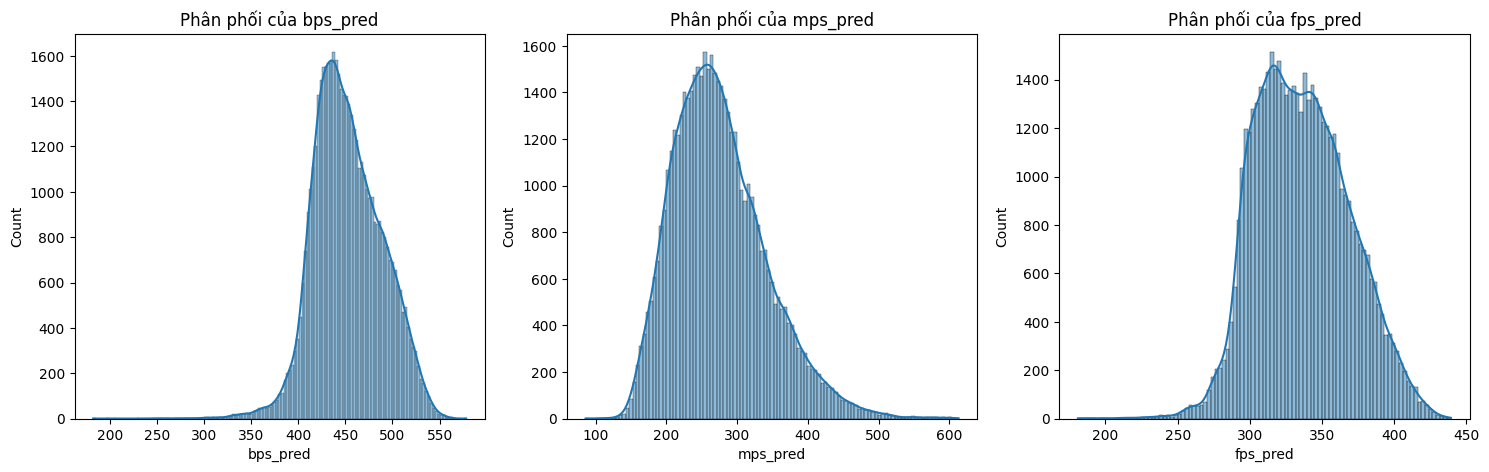

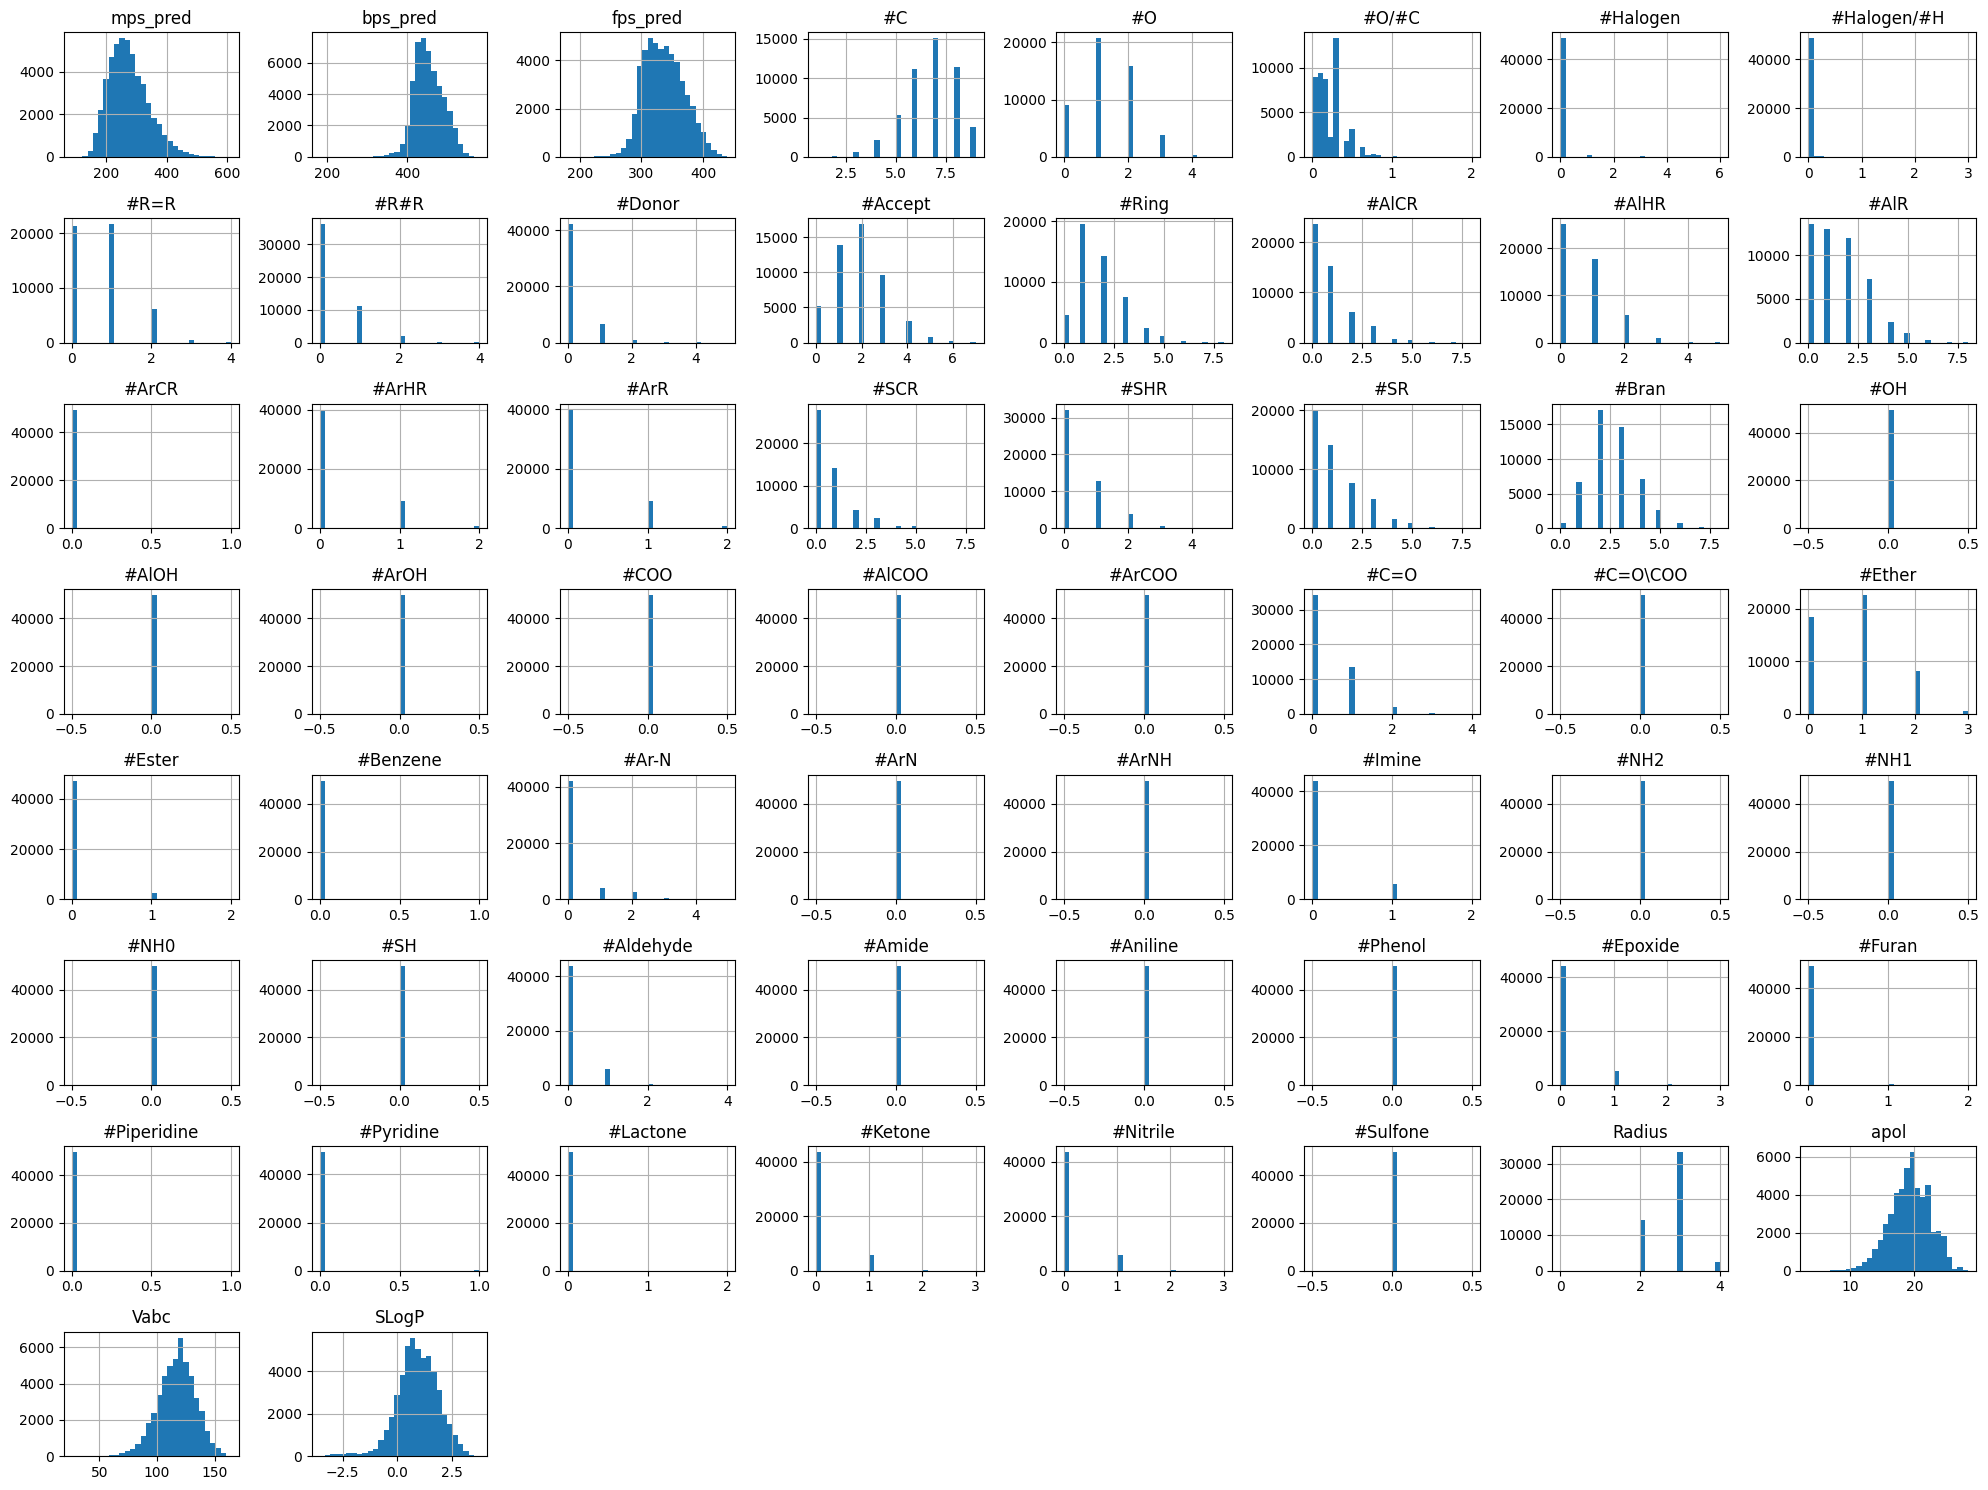

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Phân phối target variables
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, target in enumerate(['bps_pred', 'mps_pred', 'fps_pred']):
    sns.histplot(df2[target], kde=True, ax=axes[i])
    axes[i].set_title(f'Phân phối của {target}')
plt.show()

# Phân phối các features numeric
numeric_cols = df2.select_dtypes(include=['float64', 'int64']).columns
df2[numeric_cols].hist(bins=30, figsize=(20, 15))
plt.tight_layout()
plt.show()

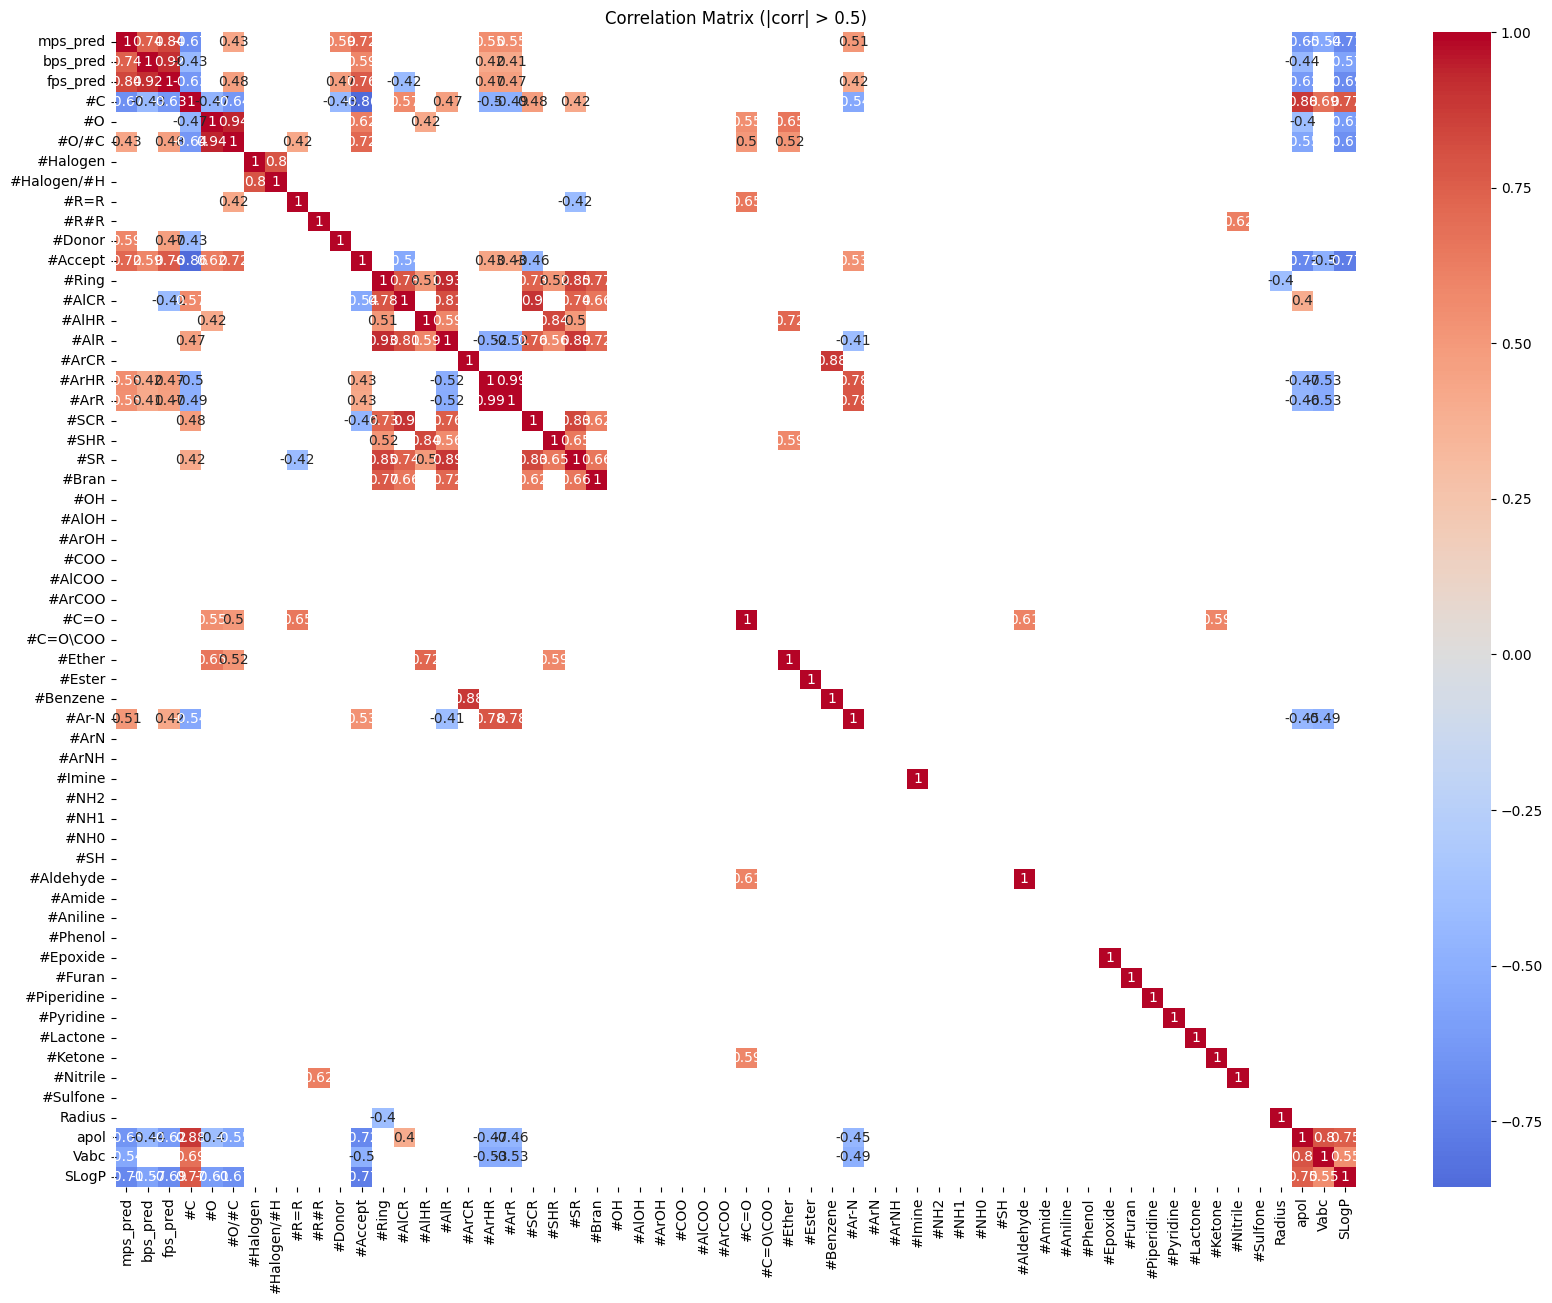


Tương quan với bps_pred:
bps_pred    1.000000
fps_pred    0.917377
mps_pred    0.739511
#Accept     0.593652
#ArHR       0.416733
#ArR        0.413192
#Donor      0.388193
#Ar-N       0.344290
#Nitrile    0.325668
#O/#C       0.315076
#SCR       -0.316860
#AlCR      -0.325096
#C         -0.433733
apol       -0.436198
SLogP      -0.569701
Name: bps_pred, dtype: float64

Tương quan với mps_pred:
mps_pred    1.000000
fps_pred    0.836348
bps_pred    0.739511
#Accept     0.718960
#Donor      0.588905
#ArHR       0.551093
#ArR        0.546320
#Ar-N       0.511420
#O/#C       0.428866
#R=R        0.384966
#O          0.321351
#SR        -0.305520
#SCR       -0.357929
#AlCR      -0.364144
Vabc       -0.543222
apol       -0.646219
#C         -0.673106
SLogP      -0.713168
Name: mps_pred, dtype: float64

Tương quan với fps_pred:
fps_pred    1.000000
bps_pred    0.917377
mps_pred    0.836348
#Accept     0.761773
#O/#C       0.475934
#Donor      0.472208
#ArHR       0.471646
#ArR        0.467538

In [39]:
# Ma trận tương quan
corr_matrix = df2.select_dtypes(include=['float64', 'int64']).corr()
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix[(corr_matrix > 0.4) | (corr_matrix < -0.4)], 
            annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix (|corr| > 0.5)')
plt.show()

# Tương quan với target
targets = ['bps_pred', 'mps_pred', 'fps_pred']
for target in targets:
    corr_with_target = df2.select_dtypes(include=['float64', 'int64']).corr()[target].sort_values(ascending=False)
    print(f"\nTương quan với {target}:")
    print(corr_with_target[abs(corr_with_target) > 0.3])


Feature importance cho bps_pred:
        feature  importance
8       #Accept    0.385855
28       #Ether    0.097634
7        #Donor    0.078487
0            #C    0.075415
54        SLogP    0.055281
49     #Nitrile    0.043422
52         apol    0.032356
2         #O/#C    0.029994
11        #AlHR    0.027281
53         Vabc    0.019657
19        #Bran    0.017932
29       #Ester    0.016170
9         #Ring    0.014869
51       Radius    0.014550
3      #Halogen    0.012613
5          #R=R    0.010358
4   #Halogen/#H    0.007692
26         #C=O    0.007562
15         #ArR    0.005592
31        #Ar-N    0.005030


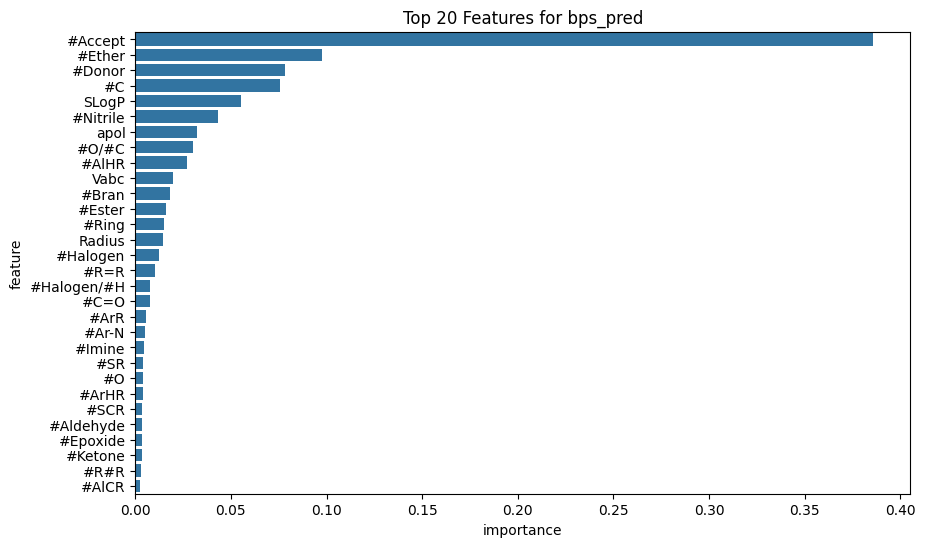


Feature importance cho mps_pred:
    feature  importance
8   #Accept    0.363451
7    #Donor    0.280636
54    SLogP    0.079585
52     apol    0.041779
19    #Bran    0.030179
53     Vabc    0.024170
31    #Ar-N    0.022517
5      #R=R    0.020305
14    #ArHR    0.017386
15     #ArR    0.013884
28   #Ether    0.013610
11    #AlHR    0.012790
16     #SCR    0.011327
9     #Ring    0.010447
2     #O/#C    0.009126
0        #C    0.007309
51   Radius    0.006624
6      #R#R    0.004742
17     #SHR    0.004012
10    #AlCR    0.003635


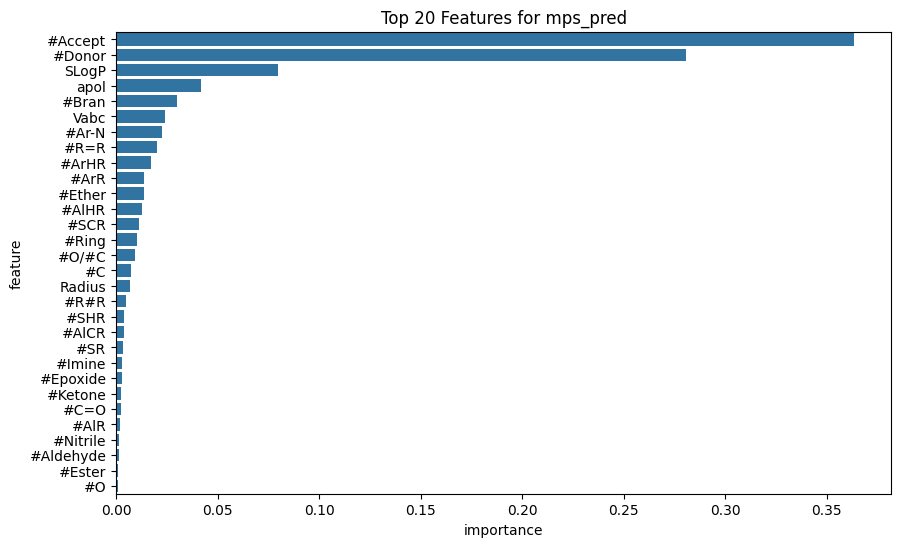


Feature importance cho fps_pred:
     feature  importance
8    #Accept    0.577547
28    #Ether    0.084083
7     #Donor    0.064554
52      apol    0.052336
0         #C    0.034437
54     SLogP    0.034227
2      #O/#C    0.023188
11     #AlHR    0.022149
49  #Nitrile    0.017496
5       #R=R    0.010851
53      Vabc    0.009443
34    #Imine    0.008230
19     #Bran    0.008100
51    Radius    0.008034
15      #ArR    0.005693
29    #Ester    0.005674
6       #R#R    0.004828
9      #Ring    0.004186
31     #Ar-N    0.002799
14     #ArHR    0.002639


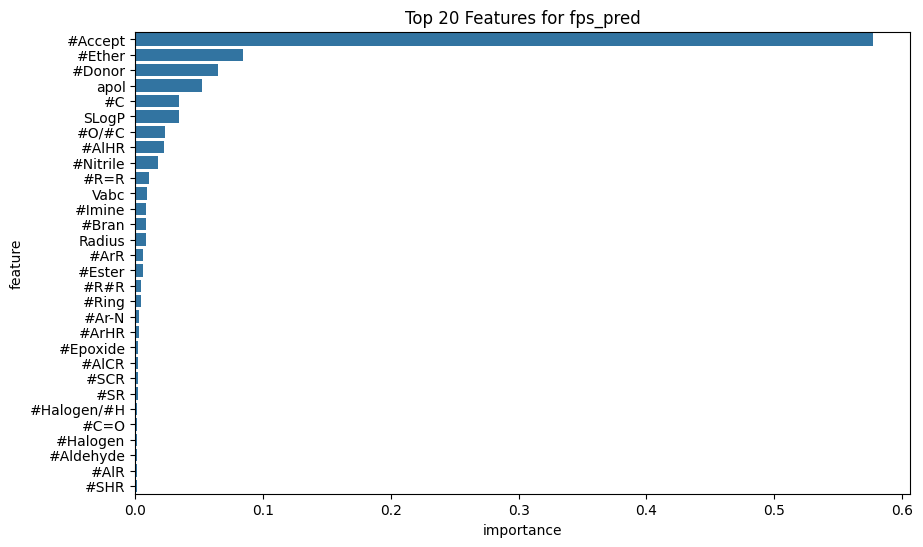

In [40]:
# frature importance từ mô hình
from sklearn.ensemble import RandomForestRegressor

# Tính feature importance cho từng target
for target in ['bps_pred', 'mps_pred', 'fps_pred']:
    X = df2.drop(columns=['bps_pred', 'mps_pred', 'fps_pred', 'canonical_smiles'])
    y = df2[target]
    
    model = RandomForestRegressor(n_estimators=100, random_state=7)
    model.fit(X, y)
    
    importance = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nFeature importance cho {target}:")
    print(importance.head(20))
    
    # Visualize top 20 features
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=importance.head(30))
    plt.title(f'Top 20 Features for {target}')
    plt.show()

In [41]:
# chọn feaatures bằng thống kê
from sklearn.feature_selection import SelectKBest, mutual_info_regression

for target in ['bps_pred', 'mps_pred', 'fps_pred']:
    X = df2.drop(columns=['bps_pred', 'mps_pred', 'fps_pred', 'canonical_smiles'])
    y = df2[target]
    
    # Chọn top k features dựa trên mutual information
    selector = SelectKBest(score_func=mutual_info_regression, k=20)
    selector.fit(X, y)
    
    selected_features = X.columns[selector.get_support()]
    scores = selector.scores_[selector.get_support()]
    
    print(f"\nTop features cho {target} (Mutual Info):")
    print(pd.DataFrame({'feature': selected_features, 'score': scores})
          .sort_values('score', ascending=False))


Top features cho bps_pred (Mutual Info):
     feature     score
17      apol  0.555644
18      Vabc  0.432237
19     SLogP  0.398665
5    #Accept  0.264561
2      #O/#C  0.239924
0         #C  0.236815
9      #ArHR  0.097390
10      #ArR  0.096663
7      #AlCR  0.096605
4     #Donor  0.090209
11      #SCR  0.086786
1         #O  0.086367
8       #AlR  0.083957
12       #SR  0.082973
15     #Ar-N  0.081905
16  #Nitrile  0.080195
3       #R=R  0.063236
6      #Ring  0.057941
13      #C=O  0.055471
14    #Ether  0.038406

Top features cho mps_pred (Mutual Info):
    feature     score
17     apol  0.646371
19    SLogP  0.549744
18     Vabc  0.544190
5   #Accept  0.416835
0        #C  0.365092
2     #O/#C  0.299270
4    #Donor  0.189883
9     #ArHR  0.166678
10     #ArR  0.164742
16    #Ar-N  0.156962
1        #O  0.120561
6     #AlCR  0.104844
11     #SCR  0.097699
8      #AlR  0.096336
3      #R=R  0.092241
13      #SR  0.092131
7     #AlHR  0.080433
15   #Ether  0.075832
14     #C=O  0.


PCA cho bps_pred:
Số lượng thành phần chính được giữ lại: 34
Tổng phương sai giải thích được: 1.0000


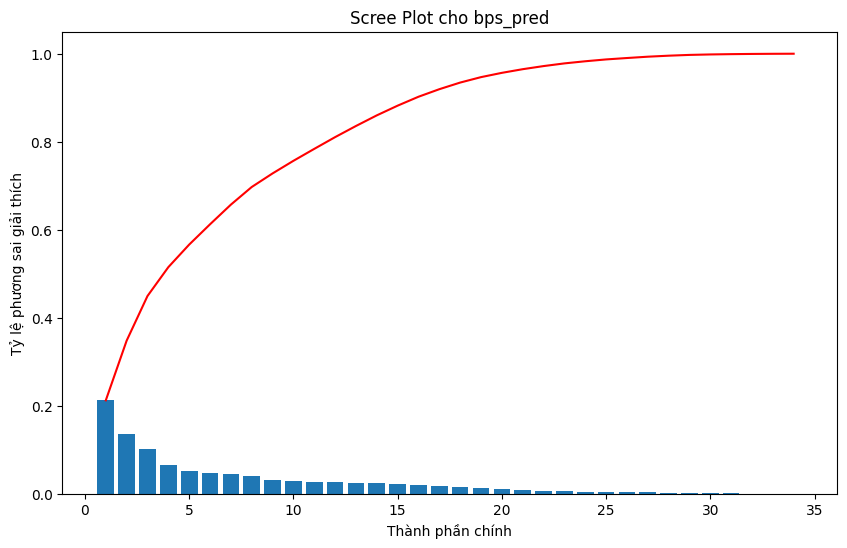


Top 20 features quan trọng nhất theo PCA:
#Ar-N        4.653341
SLogP        4.558657
#R=R         4.556691
#R#R         4.416364
#O/#C        4.321324
#Donor       4.185644
#Bran        4.150873
#Imine       4.039063
#Accept      3.989861
#Ketone      3.981529
#Ether       3.967761
#Aldehyde    3.922427
#Ring        3.768903
#C           3.740790
#SHR         3.715337
#AlCR        3.681203
#Ester       3.647895
#Nitrile     3.637287
#SCR         3.495742
#O           3.466506
dtype: float64

PCA cho mps_pred:
Số lượng thành phần chính được giữ lại: 34
Tổng phương sai giải thích được: 1.0000


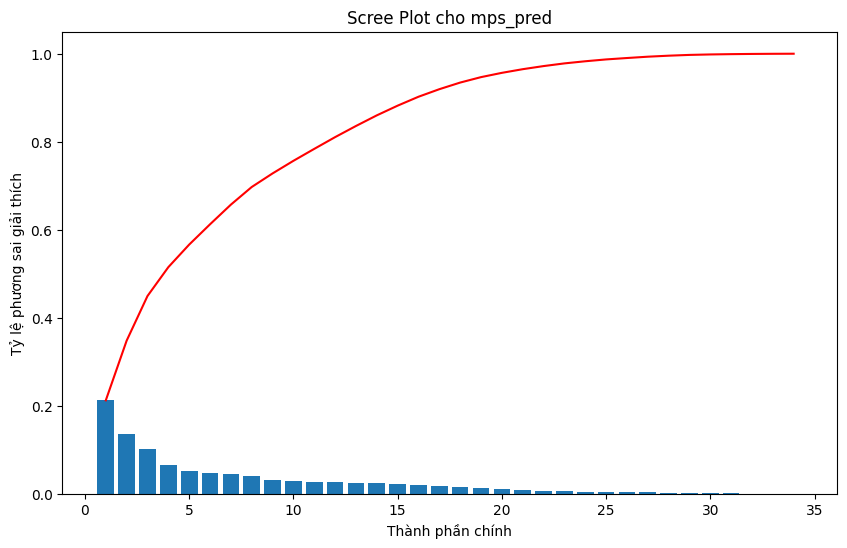


Top 20 features quan trọng nhất theo PCA:
#Ar-N        4.653341
SLogP        4.558657
#R=R         4.556691
#R#R         4.416364
#O/#C        4.321324
#Donor       4.185644
#Bran        4.150873
#Imine       4.039063
#Accept      3.989861
#Ketone      3.981529
#Ether       3.967761
#Aldehyde    3.922427
#Ring        3.768903
#C           3.740790
#SHR         3.715337
#AlCR        3.681203
#Ester       3.647895
#Nitrile     3.637287
#SCR         3.495742
#O           3.466506
dtype: float64

PCA cho fps_pred:
Số lượng thành phần chính được giữ lại: 34
Tổng phương sai giải thích được: 1.0000


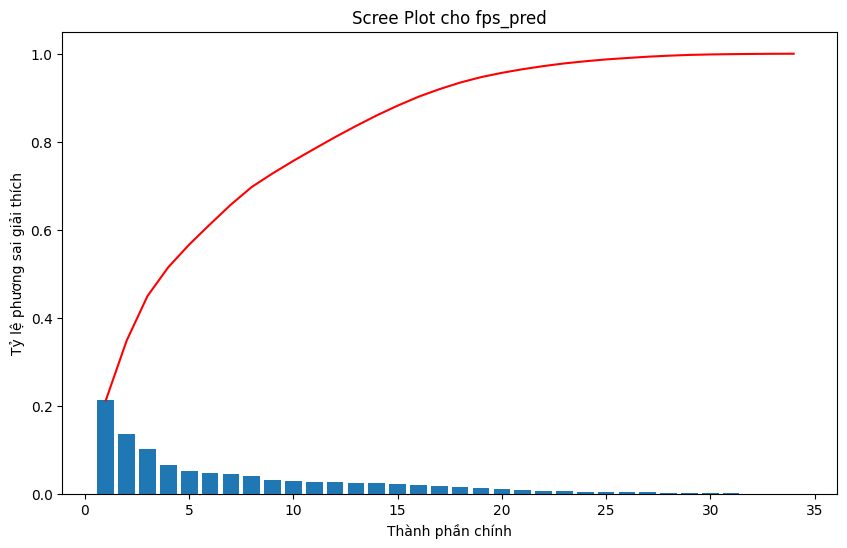


Top 20 features quan trọng nhất theo PCA:
#Ar-N        4.653341
SLogP        4.558657
#R=R         4.556691
#R#R         4.416364
#O/#C        4.321324
#Donor       4.185644
#Bran        4.150873
#Imine       4.039063
#Accept      3.989861
#Ketone      3.981529
#Ether       3.967761
#Aldehyde    3.922427
#Ring        3.768903
#C           3.740790
#SHR         3.715337
#AlCR        3.681203
#Ester       3.647895
#Nitrile     3.637287
#SCR         3.495742
#O           3.466506
dtype: float64


In [42]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# PCA để giảm chiều và chọn features quan trọng
for target in ['bps_pred', 'mps_pred', 'fps_pred']:
    X = df2.drop(columns=['bps_pred', 'mps_pred', 'fps_pred', 'canonical_smiles'])
    y = df2[target]
    
    # Chuẩn hóa dữ liệu trước khi thực hiện PCA
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Thực hiện PCA
    pca = PCA(n_components=0.9999)  # Giữ lại các thành phần giải thích 95% phương sai
    pca_result = pca.fit_transform(X_scaled)
    
    # In ra số lượng thành phần được giữ lại
    print(f"\nPCA cho {target}:")
    print(f"Số lượng thành phần chính được giữ lại: {pca.n_components_}")
    print(f"Tổng phương sai giải thích được: {sum(pca.explained_variance_ratio_):.4f}")
    
    # Hiển thị tỷ lệ phương sai được giải thích bởi mỗi thành phần
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
             np.cumsum(pca.explained_variance_ratio_), 'r-')
    plt.xlabel('Thành phần chính')
    plt.ylabel('Tỷ lệ phương sai giải thích')
    plt.title(f'Scree Plot cho {target}')
    plt.show()
    
    # Xác định các features quan trọng nhất thông qua PCA loadings
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{i+1}' for i in range(pca.n_components_)],
        index=X.columns
    )
    
    # Lấy top features có ảnh hưởng lớn nhất đến các principal components
    abs_loadings = abs(loadings).sum(axis=1).sort_values(ascending=False)
    print("\nTop 20 features quan trọng nhất theo PCA:")
    print(abs_loadings.head(20))